In [1]:
#loading all the required python libraries
import librosa 
import librosa.display
import os
import soundfile 
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import nlpaug
import nlpaug.augmenter.audio as naa
import seaborn as sns
plt.style.use('ggplot')

In [2]:
file = '/Users/prem/Desktop/Speech_Corpus/final_dataframe.xlsx'

In [3]:
df = pd.read_excel(file)

In [4]:
df

,wave_id,transcript,Speaker,Gender,Age_Range,Pronunciation_dialect
0,en-0190,may be present this evening and early tomorrow...,1,Male,Adult,American English
1,en-0189,The potential for freezing rain and hazardous ...,1,Male,Adult,American English
2,en-0185,"There is, for example, no assurance that",1,Male,Adult,American English
3,en-0186,the posted prices represent prevailing market ...,1,Male,Adult,American English
4,en-0187,Very belated reply. I am cleaning up old e-mai...,1,Male,Adult,American English
...,...,...,...,...,...,...
57867,a0161,Take away their foreman and they wouldn't be w...,5906,Male,Youth,American English
57868,a0162,"That's the sub-foreman, explained Thorpe.",5906,Male,Youth,American English
57869,a0163,Philip made no effort to follow.,5906,Male,Youth,American English
57870,a0164,"He came first a year ago, and revealed himself...",5906,Male,Youth,American English


57872it [00:06, 8436.86it/s] 


Male audio files :  53695
Female audio files :  4177


<BarContainer object of 2 artists>

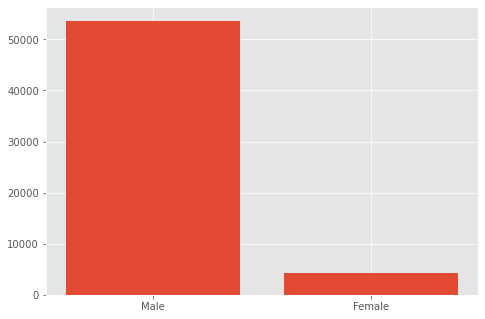

In [5]:
# count male & female audio files
gender = {'01':'Male','02':'Female'}
count={'01':0,'02':0}

for index_num,row in tqdm(df.iterrows()):
    if str(row["Gender"]) == str('Male'):
        gen_no='01'
    else:
        gen_no='02'
    
    count[gen_no]=count[gen_no]+1

print('Male audio files : ',count['01'])
print('Female audio files : ',count['02'])
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])
ax.bar(gender.values(),count.values())

Text(0.5, 0, 'count')

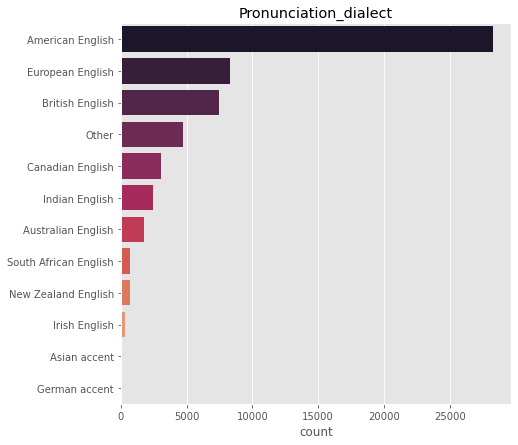

In [6]:
plt.figure(figsize=(7,7))
rest = df['Pronunciation_dialect'].value_counts()

sns.barplot(x = rest,y=rest.index,palette="rocket")
plt.title("Pronunciation_dialect")
plt.xlabel("count")

In [7]:
df.Age_Range.unique()

array(['Adult', 'Youth', 'Senior'], dtype=object)

57872it [00:05, 10582.24it/s]


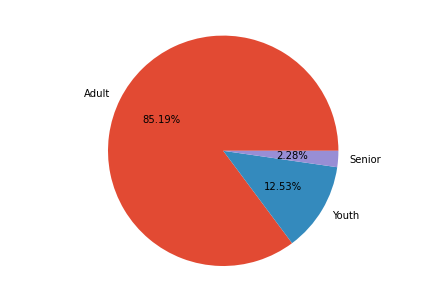

In [8]:
# age_range of audio files
age = {'01':'Adult','02':'Youth','03':'Senior'}
total = {'01':0,'02':0,'03':0}

for index_num,row in tqdm(df.iterrows()):
    if str(row["Age_Range"]) == str('Adult'):
        num = '01'
    elif str(row["Age_Range"]) == str('Youth'):
        num = '02'
    else:
        num = '03'
    
    total[num] = total[num]+1

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
field = age.values()
value = total.values()
ax.pie(value, labels = field,autopct='%1.2f%%')
plt.show()


In [9]:
#function to extract features from an audio file
def extract_feature(file_name):
    result = np.array([])
    n0 = 9000
    n1 = 9100

    sound_file = soundfile.SoundFile(file_name)  
    data = sound_file.read()
    sample_rate = sound_file.samplerate
    # adding loudness to audio files
    aug = naa.LoudnessAug(factor=(2, 5))
    X = aug.augment(data)
    stft = np.abs(librosa.stft(X))
    
    spectral_bw = np.mean(librosa.feature.spectral_bandwidth(y=X, sr=sample_rate)[0])
    result = np.append(result,spectral_bw)
    
    spectral_rolloff = np.mean(librosa.feature.spectral_rolloff(X, sr=sample_rate)[0])
    result = np.append(result,spectral_rolloff)

    spectral_flatness = np.mean(librosa.feature.spectral_flatness(y=X))
    result = np.append(result,spectral_flatness)

    rms = np.mean(librosa.feature.rms(y=X)[0])
    result = np.append(result,rms)

    zero_crossings_rate = sum(librosa.zero_crossings(X[n0:n1], pad=False))
    result = np.append(result,zero_crossings_rate)
    
    spectral_centroids = np.mean(librosa.feature.spectral_centroid(X, sr=sample_rate)[0])
    result = np.append(result,spectral_centroids)

    mfccs = np.mean(librosa.feature.mfcc(X, sr=sample_rate,n_mfcc=13).T, axis=0)
    result = np.append(result,mfccs)
   
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    result = np.append(result,mel)
    
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    result = np.append(result,chroma)

    spectral_contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)  
    result = np.append(result,spectral_contrast)

    # Computes the tonal centroid features (tonnetz)
    H = librosa.effects.harmonic(X)
    tonnetz = np.mean(librosa.feature.tonnetz(y=H, sr=sample_rate).T,axis=0)
    result = np.append(result,tonnetz)
        
    
    return result
    
    

In [10]:
rootdir ='/Users/prem/Desktop/Speech_Corpus'

In [11]:
extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = os.path.join(os.path.abspath(rootdir),str(row["Speaker"])+'/','wav/',str(row["wave_id"])+'.wav')
    final_class_labels = row["Gender"]
    data = extract_feature(file_name)
    extracted_features.append([final_class_labels,data])

185it [01:36,  2.05it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")
390it [03:24,  2.39it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=470
  warnings.warn(
395it [03:25,  2.77it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=491
  warnings.warn(
1197it [21:37,  2.32it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=407
  warnings.warn(
1304it [22:35,  2.27it/s]/opt/anaconda3/lib/python3.8/site-packages/librosa/core/spectrum.py:222: UserWarning: n_fft=512 is too small for input signal of length=313
  warnings.warn(
2084it [30:44,  1.26it/s]/opt/anaconda3/lib/

RuntimeError: Error opening '/Users/prem/Desktop/Speech_Corpus/565/wav/b0415.wav': System error.

In [12]:
# converting extracted_features to Pandas dataframe
extracted_features_df = pd.DataFrame(extracted_features,columns=['gender','feature'])
extracted_features_df.head()

,gender,feature
0,Male,"[1588.4204615524898, 3006.904069767442, 0.0111..."
1,Male,"[1659.7332633230642, 3447.0920138888887, 0.025..."
2,Male,"[1547.9571444162355, 3208.797770700637, 0.0233..."
3,Male,"[1734.4844188954976, 3637.2884114583335, 0.030..."
4,Male,"[1568.22401035777, 3022.361288265306, 0.010635..."


In [13]:
extracted_features_df.shape

(5491, 2)

In [14]:
# Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['gender'].tolist())

In [15]:
X.shape

(5491, 172)

In [16]:
y=np.array(pd.get_dummies(y))

In [17]:
y.shape

(5491, 2)

In [18]:
a = pd.DataFrame(extracted_features_df['gender'])

In [27]:
a.shape

(5491, 1)

In [19]:
b = pd.DataFrame(X)

In [28]:
b.shape

(5491, 172)

In [24]:
feature = a.join(b)

In [25]:
# extracted features data_frame of first 5491 audio files
feature

,gender,0,1,2,3,4,5,6,7,8,...,162,163,164,165,166,167,168,169,170,171
0,Male,1588.420462,3006.904070,0.011178,0.077064,0.0,1463.729547,-314.200628,84.907364,-12.184678,...,15.734279,18.067453,21.067293,21.173581,-0.010010,-0.040958,-0.023406,-0.030344,0.008527,0.001133
1,Male,1659.733263,3447.092014,0.025084,0.036329,2.0,1754.312549,-341.338946,86.472343,-12.158928,...,16.183270,18.028187,19.740503,23.167726,-0.033385,-0.020667,0.000984,-0.056438,0.006307,-0.002524
2,Male,1547.957144,3208.797771,0.023337,0.053739,2.0,1791.561653,-316.566046,87.275594,-22.120346,...,16.872115,18.739833,20.858876,23.081607,0.017158,0.001918,-0.109651,-0.017986,0.016157,0.017858
3,Male,1734.484419,3637.288411,0.030065,0.073100,4.0,1879.426825,-294.239541,70.548754,-6.073326,...,15.660238,17.852499,19.241792,23.452189,-0.001944,-0.025529,-0.013297,-0.078958,-0.002825,-0.008025
4,Male,1568.224010,3022.361288,0.010636,0.086489,0.0,1480.785714,-290.140921,84.270453,-13.185572,...,16.112455,18.020333,22.267154,21.608937,-0.037684,-0.014493,0.007131,-0.075425,0.018354,-0.009237
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5486,Male,1498.229945,3065.333946,0.007146,0.165752,6.0,1422.619358,-150.688786,108.285110,-15.285637,...,16.171039,16.247485,17.998764,29.329612,-0.010109,0.069957,0.072780,0.054880,0.039562,-0.031337
5487,Male,1516.138398,3227.726064,0.009674,0.109649,10.0,1636.588307,-167.593660,101.002839,-27.170693,...,15.279733,15.532593,18.717092,27.141536,0.006625,0.070400,0.137487,0.085347,0.009241,-0.035111
5488,Male,1575.393555,3270.138889,0.008967,0.100517,3.0,1527.468590,-178.457897,98.727910,-9.724390,...,14.543267,15.054617,18.442002,30.097786,0.002496,0.103572,0.044003,0.006790,0.022838,-0.023991
5489,Male,1550.980785,3221.617880,0.010073,0.123514,9.0,1535.443566,-185.604472,98.785009,-4.523971,...,15.701860,15.776977,17.250660,29.037758,0.023386,0.167147,0.086315,0.060375,0.083155,-0.048302


In [29]:
feature.to_csv(r'/Users/prem/Desktop/Speech_Corpus/feature.csv')